# Figure 2 & Supp. Fig. 1B
The goal of this experiment is to test if reafference matters for the future OMR drive.

Fish experienced 5-s closed-loop motion (*priming*) with different gains, 2-s waiting period, followed by 10-s open-loop motion (*probe*).

Please see **Table S1** for the detail of the stimulus structure.

In [7]:
# Import packages
import numpy as np
import os
from bouter import EmbeddedExperiment
from matplotlib import pyplot as plt
import colorcet as cc
from scipy.stats import wilcoxon, binned_statistic, friedmanchisquare
from homr_util import *
from tqdm import tqdm

In [2]:
# Tweaking matplotlib 
set_rcParams()

In [3]:
# Find data
data_dir = "./data/fig2"
fish_list = os.listdir(data_dir)
n_fish = len(fish_list)
print('total',n_fish,'fish')

total 30 fish


## Analysis
- Loop around the fish directories, load behavioral data (i.e. swim effort)
- Down sample data to 20 Hz
- Cut out snippet around each stimulus epoch, sort by epoch type

In [11]:
# downsampling to 20Hz
bin_dt = 1/20  
# bin edges for downsampling
time_bin = np.arange(0, 22, bin_dt)  # each trial is 22 s long (5 s wait, 5 s conditioning, 2 s wait, 10 s probe)
# bin centers
binned_t = (time_bin[1:]+time_bin[:-1])/2

# list to compile data
all_traces   = [] # x (= image displacement)
all_fvtraces = [] # swim velocity of fish (before applying gain)
all_prebouts = [] # number of bouts during the waiting period (used for sorting)
all_bdur_pre = []
all_bdur_probe = []

# Go through all fish
for fish in tqdm(fish_list):
    
    # load data
    exp = EmbeddedExperiment(data_dir + '/' + fish)
    slog = exp['stimulus']['log']
    
    ## time trace extraction
    # timestamp
    t_s = exp.stimulus_log['t'].to_numpy()
    # image position
    x = exp.stimulus_log['CLLDGOO_x'].to_numpy()
    # fish velocity, rectified at bout threshold (0.05 rad), but before closed loop gain
    fv = exp.stimulus_log['CLLDGOO_fish_vel'].to_numpy() * exp.stimulus_log['CLLDGOO_fish_swimming'].to_numpy() # before gain
    
    # extract bout with bouter
    bouts = exp.get_bouts()
    bsum = exp.get_bout_properties()
    t_bout = bsum['t_start'].to_numpy()
    bdur = bsum['duration'].to_numpy()

    # lists of lists to store data
    traces   = [[] for i in range(3)] # 3 gain conditions
    fvtraces = [[] for i in range(3)] # 3 gain conditions
    prebouts = [[] for i in range(3)] # 3 gain conditions
    bdur_pre = [[] for i in range(3)] 
    bdur_probe = []
    
    # go through epochs
    for epoch in slog:
        
        # figure out the gain condition and conver that to an integer index
        epoch_id = int(epoch['pre_gain'] / 0.5 - 1)
        
        # calculate time stamps
        duration = epoch['duration']
        t_end = epoch['t_stop']
        
        # cut out snippets (trust end more than start)
        this_epoch_ind = (t_s>(t_end-duration)) * (t_s<=t_end)
        
        # baseline subtraction
        this_t = t_s[this_epoch_ind]
        this_t = this_t - (t_end - duration)
        this_x = x[this_epoch_ind]
        this_x = this_x - this_x[0]
        this_fv = fv[this_epoch_ind] * epoch['orig_gain'] 

        # binning
        binned_x = binned_statistic(this_t, this_x, bins=time_bin)[0]
        binned_fv = binned_statistic(this_t, this_fv, bins=time_bin)[0]
        
        # count how many bouts fish did in the priming pulse
        is_this_pre_bout = (t_bout>(t_end-duration+5)) * (t_bout<=t_end-10)
        is_this_probe_bout = (t_bout>(t_end-duration+12))
        # We also care about bout durations, to make sure fish was noticing the gain manipulation
        if np.sum(is_this_pre_bout)>0:
            bdur_pre[epoch_id].append(bdur[is_this_pre_bout][0]) # taking the first bout in that condition
        if np.sum(is_this_probe_bout)>0:
            bdur_probe.append(bdur[is_this_probe_bout][0])
        
        # saving
        prebouts[epoch_id].append(np.sum(is_this_pre_bout))
        traces[epoch_id].append(binned_x)
        fvtraces[epoch_id].append(binned_fv)
    
    # concatenate all fish data
    all_prebouts.append(prebouts)
    all_traces.append(traces)
    all_fvtraces.append(fvtraces)
    all_bdur_pre.append(bdur_pre)
    all_bdur_probe.append(bdur_probe)

100%|████████████████████████████████████████████████████████████████████████| 30/30 [00:17<00:00,  1.76it/s]


In [12]:
# Conversion to numpy array 
all_prebouts = np.asarray(all_prebouts)
all_traces   = np.asarray(all_traces)
all_fvtraces = np.asarray(all_fvtraces)

# average velocity during probe for each fish, condition, trial
# to be correlated with #prebouts per fish 
probe_mean_fv = np.nanmean(all_fvtraces[:, :, :, (binned_t>=12)*(binned_t<22)], axis=3)

# swam distance in the conditioning phase
# just take the location during the waiting period between conditioning and probe
# and take the negative of that (doing nanmean because the value can be missing sometimes)
pre_distance_swam = 25 - np.nanmean(all_traces[:, :, :, (binned_t>10.5)*(binned_t<12)], axis=3)

# correlation of the two
pre_probe_corr = np.empty(n_fish)
for i in range(n_fish):
    C = np.corrcoef(probe_mean_fv[i, :, :].flatten(), pre_distance_swam[i, :, :].flatten())
    pre_probe_corr[i] = C[0,1]

In [13]:
# stratify data by bout counts
max_n_bouts_to_consider = 3
n_rep = all_prebouts.shape[2]
stratified_mean_fv = np.empty((max_n_bouts_to_consider+1, n_fish, 3))

for nb in range(max_n_bouts_to_consider+1):
    for f in range(n_fish):
        for i in range(3):
            temp = all_prebouts[f, i, :]==nb
            stratified_mean_fv[nb, f, i] = np.nanmean(probe_mean_fv[f, i, temp])

C:\Users\ryosuke\AppData\Local\Temp\ipykernel_13936\3463225670.py:10: RuntimeWarning: Mean of empty slice
  stratified_mean_fv[nb, f, i] = np.nanmean(probe_mean_fv[f, i, temp])


In [14]:
# average bout durations
probe_mean_bdur = np.asarray([np.mean(x) for x in all_bdur_probe])
pre_mean_bdur = []
for temp in all_bdur_pre:
    pre_mean_bdur.append([np.mean(x) for x in temp])
pre_mean_bdur = np.vstack(pre_mean_bdur).T
all_mean_bdur = np.vstack((probe_mean_bdur, pre_mean_bdur))

## Panels

### Fig. 2B (global average swim effort)

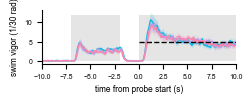

In [17]:
# mean time trace
trial_mean_fv = np.nanmean(all_fvtraces, axis=2)

# show time traces colored by gain conditions (legend not shown)
fig, ax = plt.subplots(1, 1, figsize=(2.5, 0.7))
for i in range(3):
    plot_mean_sem(ax, binned_t-12, trial_mean_fv[:, i, :], color=cc.cm.CET_I3(i/2.0))
    
# plot the swim effort at which fish would have canceled the stimulus
# (they didn't, because open loop)
ax.plot((0,10), (5,5), 'k--')

# show where priming and probe happened
ax.fill_between((-7,-2),(0,0),(12,12),color=(0.5,0.5,0.5), alpha=0.2, zorder=-3)
ax.fill_between((0,10),(0,0),(12,12),color=(0.5,0.5,0.5), alpha=0.2, zorder=-3)

ax.set_xlabel('time from probe start (s)')
ax.set_ylabel('swim vigor (1/30 rad)')
ax.set_xlim([-10, 10])
toggle_spines(ax, 0, 1, 0, 1)

plt.savefig('./svgs/Fig2B.svg', format='svg')
plt.show()

### Figure 2CD (priming distance vs. probe swim effort for an example fish & correlation across population)

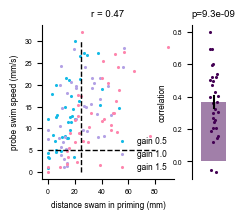

In [19]:
# Compare mean velocity in the probe period (for 1 fish)
fid = 4 # just an example fish

fig, ax = plt.subplots(1, 2, figsize=(2.5, 2), width_ratios=(3,1))

# mock variable for labeling
for i in range(3):
    ax[0].scatter(pre_distance_swam[fid, i, :], probe_mean_fv[fid, i, :], color=cc.cm.CET_I3(i/2.0), label='gain {}'.format(i/2+0.5), s=5)
ax[0].set_xlabel('distance swam in priming (mm)')
ax[0].set_ylabel('probe swim speed (mm/s)')
ax[0].set_title('r = {:0.2}'.format(pre_probe_corr[fid]))
ax[0].legend()
ax[0].plot([25, 25], [0, 30], 'k--')
ax[0].plot([0, 80], [5, 5], 'k--')

scatter_bar([pre_probe_corr], ax=ax[1])
ax[1].set_title('p={:0.2}'.format(wilcoxon(pre_probe_corr)[1]))
ax[1].set_ylabel('correlation')
ax[1].set_xlim([-0.7,0.7])
toggle_spines(ax[0], 0, 1, 0, 1)
toggle_spines(ax[1], 0, 0, 0, 1)
    
plt.savefig('./svgs/Fig2CD.svg', format='svg')
plt.show()

### Fig. 2E (Probe swim effort stratified by the priming swim amount)

#bout in priming = 0 N = 30 fish Friedman p = 4.00e-01
#bout in priming = 1 N = 30 fish Friedman p = 4.07e-01
#bout in priming = 2 N = 29 fish Friedman p = 6.09e-01
#bout in priming = 3 N = 15 fish Friedman p = 3.44e-01


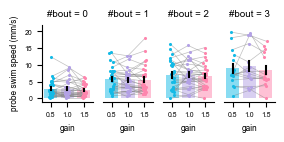

In [25]:
# stratify data by bout counts
fig, ax = plt.subplots(1, max_n_bouts_to_consider+1, figsize=(3, 1))

# we ignore fish that did not have trials with all the bout numbers
# so that we can run paired statistical tests
for i in range(max_n_bouts_to_consider+1):
    this_data = stratified_mean_fv[i]
    fish_to_use = ~np.any(np.isnan(this_data), axis=1)
    p = scatter_bar(this_data[fish_to_use, :].T, ax=ax[i], color=cc.cm.CET_I3, connect=True, condnames=('0.5', '1.0', '1.5'))
    print('#bout in priming =',i,
          'N =',np.sum(fish_to_use), 'fish',
          'Friedman p = {:0.2e}'.format(friedmanchisquare(*this_data[fish_to_use].T)[1]))

for i in range(max_n_bouts_to_consider+1):
    toggle_spines(ax[i], 0, 1, 0, i==0)
    ax[i].set_ylim(-1,22)
    ax[i].set_xlabel('gain')
    ax[i].set_title('#bout = {}'.format(i))
ax[0].set_ylabel('probe swim speed (mm/s)')

plt.savefig('./svgs/Fig2E.svg', format='svg')
plt.show()

### Fig. S2B (Bout duration comparison across gain condition)

Friedman p = 3.89e-05


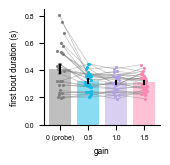

In [27]:
plt.figure(figsize=(1.5, 1.5))

color_list = ((0.5,0.5,0.5), cc.cm.CET_I3(0), cc.cm.CET_I3(0.5), cc.cm.CET_I3(1.0))
p = scatter_bar(all_mean_bdur, connect=True, color=color_list, condnames=('0 (probe)', '0.5', '1.0', '1.5'))
plt.xlabel('gain')
plt.ylabel('first bout duration (s)')
toggle_spines(plt.gca(), 0, 1, 0, 1)
print('Friedman p = {:0.2e}'.format(friedmanchisquare(*all_mean_bdur)[1]))

plt.savefig('./svgs/FigS2B.svg', format='svg')
plt.show()